# Preparação dos dados

Carregando os arquivos .csv que contém os dados de altura da lâmina e vazão.

## Altura

In [62]:
import pandas as pd

In [63]:
depth_df = pd.read_csv('data/water_depth_reservoir_Test1.csv')
display(depth_df)

,time (s),water depth (m),Unnamed: 2
0,0,0.45045,NaN
1,1,0.45070,NaN
2,2,0.45086,NaN
3,3,0.45096,NaN
4,4,0.45100,NaN
...,...,...,...
4313,4313,0.43703,NaN
4314,4314,0.43711,NaN
4315,4315,0.43720,NaN
4316,4316,0.43729,NaN


Devido à forma como o CSV está organizado, há uma coluna extra indesejada.

Para corrigir isso, podemos dropar essa coluna utilizando pandas.

In [64]:
depth_df = depth_df.drop(columns=[depth_df.columns[-1]])
display(depth_df)

,time (s),water depth (m)
0,0,0.45045
1,1,0.45070
2,2,0.45086
3,3,0.45096
4,4,0.45100
...,...,...
4313,4313,0.43703
4314,4314,0.43711
4315,4315,0.43720
4316,4316,0.43729


Ignorando coluna com o valor do tempo, pois a coluna de índice é equivalente.

In [65]:
depth_df = depth_df.drop(columns=[depth_df.columns[0]])
display(depth_df)

,water depth (m)
0,0.45045
1,0.45070
2,0.45086
3,0.45096
4,0.45100
...,...
4313,0.43703
4314,0.43711
4315,0.43720
4316,0.43729


## Vazão

In [66]:
discharge_df = pd.read_csv('data/discharge_inlet_Test1.csv')
display(discharge_df)

,time (s),inlet discharge (m3/s)
0,1,0.000630
1,1,0.000388
2,1,0.000203
3,1,0.000070
4,4,-0.000020
...,...,...
4313,4313,0.024713
4314,4314,0.024809
4315,4315,0.024889
4316,4316,0.024951


Na coluna indicando o tempo em segundos, o valor "1" está sendo repetido 4 vezes.

Tendo em vista que os valores da vazão mudaram para essas 4 entradas, vamos assumir que isso foi um erro de registro e que os valores são na realidade 0, 1, 2, ...

Essa mudança torna esse dataset consistente com o de altura carregado anteriormente.

Da mesma forma como fizemos anteriormente, podemos tratar a coluna de índices como nosso indicador de tempo.

In [67]:
discharge_df = discharge_df.drop(columns=[discharge_df.columns[0]])
display(discharge_df)

,inlet discharge (m3/s)
0,0.000630
1,0.000388
2,0.000203
3,0.000070
4,-0.000020
...,...
4313,0.024713
4314,0.024809
4315,0.024889
4316,0.024951


Podemos unir os dados em um só DF, o que facilita a preparação dos mesmos

In [68]:
unified_df = pd.concat([discharge_df, depth_df], axis=1)
display(unified_df)

,inlet discharge (m3/s),water depth (m)
0,0.000630,0.45045
1,0.000388,0.45070
2,0.000203,0.45086
3,0.000070,0.45096
4,-0.000020,0.45100
...,...,...
4313,0.024713,0.43703
4314,0.024809,0.43711
4315,0.024889,0.43720
4316,0.024951,0.43729


Vamos agora aplicar uma média móvel de 7 valores para suavizar os ruídos contidos nos dados obtidos experimentalmente.

Os primeiros valores serão "NaN", portanto, utilizaremos o método `dropna()` para ignorá-los.

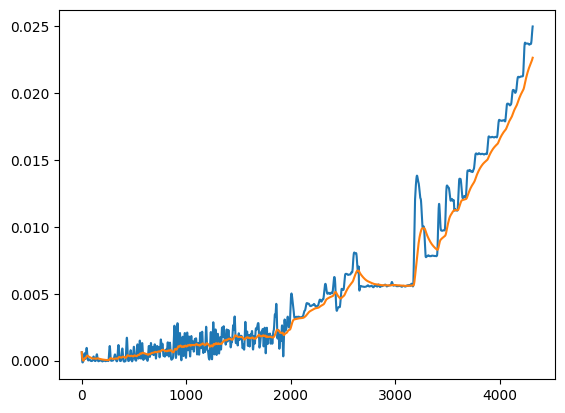

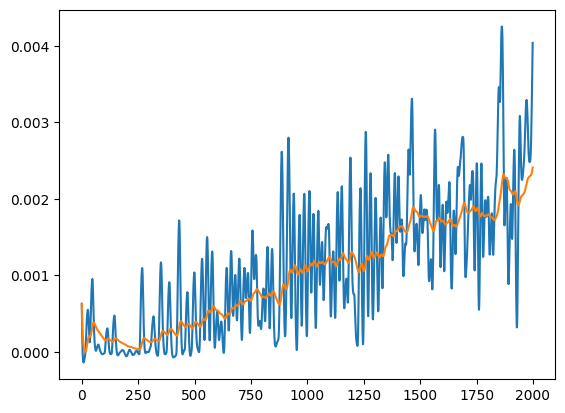

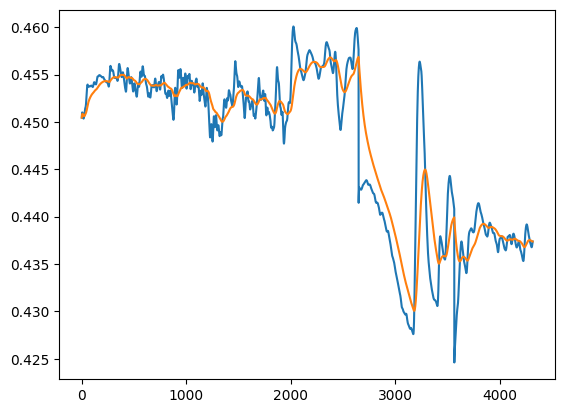

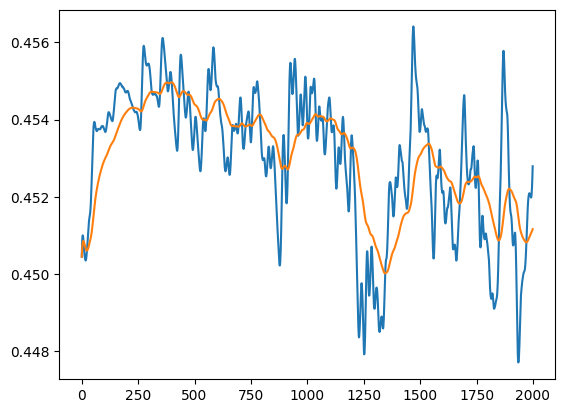

In [69]:
import matplotlib.pyplot as plt

smoothed_df = unified_df.ewm(alpha=0.0125).mean()
plt.plot(unified_df['inlet discharge (m3/s)'])
plt.plot(smoothed_df['inlet discharge (m3/s)'])
plt.show()

plt.plot(unified_df['inlet discharge (m3/s)'].values[:2000])
plt.plot(smoothed_df['inlet discharge (m3/s)'].values[:2000])
plt.show()

plt.plot(unified_df['water depth (m)'])
plt.plot(smoothed_df['water depth (m)'])
plt.show()

plt.plot(unified_df['water depth (m)'].values[:2000])
plt.plot(smoothed_df['water depth (m)'].values[:2000])
plt.show()

Convertendo o DataFrame em array numpy para facilitar acesso.

In [70]:
unified = smoothed_df.to_numpy()

Caso não queira utilizar normalização, comente a célula abaixo ou a ignore

In [71]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
unified = min_max_scaler.fit_transform(unified)
display(unified)

array([[0.02767363, 0.76120613],
       [0.02230244, 0.76590199],
       [0.01775833, 0.76948333],
       ...,
       [0.99739685, 0.27339113],
       [0.99869329, 0.27334769],
       [1.        , 0.27334213]])

# Modelagem

## Estrutura dos dados de treinamento

Como iremos trabalhar com LSTM, precisamos definir um tamanho para nossas sequências. Visto que o conjunto de dados não é muito extenso, iremos utilizar sequências com 50 valores.

Iremos coletar a sequência utilizando intervalos de 25 valores. Isto é:

Utilizaremos os índices
- [0 - 25)
- [25 - 75)
- [50 - 100)

(...)

In [72]:
SEQUENCE_SIZE = 50
SEQUENCE_GAP = 25

# Obtendo índices lower..upper
i = 0
lower = list()
upper = list()
while i + SEQUENCE_SIZE < len(unified):
  lower.append(i)
  upper.append(i + SEQUENCE_SIZE)
  print(f"[{i}, {i + SEQUENCE_SIZE})")
  i += SEQUENCE_GAP

[0, 50)
[25, 75)
[50, 100)
[75, 125)
[100, 150)
[125, 175)
[150, 200)
[175, 225)
[200, 250)
[225, 275)
[250, 300)
[275, 325)
[300, 350)
[325, 375)
[350, 400)
[375, 425)
[400, 450)
[425, 475)
[450, 500)
[475, 525)
[500, 550)
[525, 575)
[550, 600)
[575, 625)
[600, 650)
[625, 675)
[650, 700)
[675, 725)
[700, 750)
[725, 775)
[750, 800)
[775, 825)
[800, 850)
[825, 875)
[850, 900)
[875, 925)
[900, 950)
[925, 975)
[950, 1000)
[975, 1025)
[1000, 1050)
[1025, 1075)
[1050, 1100)
[1075, 1125)
[1100, 1150)
[1125, 1175)
[1150, 1200)
[1175, 1225)
[1200, 1250)
[1225, 1275)
[1250, 1300)
[1275, 1325)
[1300, 1350)
[1325, 1375)
[1350, 1400)
[1375, 1425)
[1400, 1450)
[1425, 1475)
[1450, 1500)
[1475, 1525)
[1500, 1550)
[1525, 1575)
[1550, 1600)
[1575, 1625)
[1600, 1650)
[1625, 1675)
[1650, 1700)
[1675, 1725)
[1700, 1750)
[1725, 1775)
[1750, 1800)
[1775, 1825)
[1800, 1850)
[1825, 1875)
[1850, 1900)
[1875, 1925)
[1900, 1950)
[1925, 1975)
[1950, 2000)
[1975, 2025)
[2000, 2050)
[2025, 2075)
[2050, 2100)
[2075,

Construindo sequência de inputs e outputs utilizadas pela rede.

No caso desse notebook:

- Input: Vazão
- Output: Altura da lâmina

In [73]:
import numpy as np

number_of_sequences = len(lower)
display("Quantidade de sequências", number_of_sequences)

TRAINING_SIZE = int(number_of_sequences * 0.85)
display("Quantidade de sequências de treinamento", TRAINING_SIZE)

inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
outputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
for i in range(number_of_sequences):
  inputs[i, :] = unified[lower[i]:upper[i], 1].reshape(SEQUENCE_SIZE, 1)
  outputs[i, :] = unified[lower[i]:upper[i], 0].reshape(SEQUENCE_SIZE, 1)

inputs_train = inputs[:TRAINING_SIZE]
outputs_train = outputs[:TRAINING_SIZE]
inputs_test = inputs[TRAINING_SIZE:]
outputs_test = outputs[TRAINING_SIZE:]
display("Shapes", inputs_train.shape, outputs_train.shape, inputs_test.shape, outputs_test.shape)

'Quantidade de sequências'

171

'Quantidade de sequências de treinamento'

145

'Shapes'

(145, 50, 1)

(145, 50, 1)

(26, 50, 1)

(26, 50, 1)

## Estrutura da rede neural e treinamento

Esse é uma das partes mais importantes, definir como será nossa rede neural.

Vamos começar com poucos neurônios, aumentando esse número caso a rede não consiga predizer com sucesso os valores da altura da lâmina.

In [84]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Bidirectional

input_layer = Input(shape=(SEQUENCE_SIZE, 1), name='input')
lstm = Bidirectional(LSTM(46, activation='sigmoid', return_sequences=True), name='lstm_bidirectional')(input_layer)
dense = Dense(1, 'sigmoid', name='tanh')(lstm)
model = Model(input_layer, dense, name='water_depth_to_discharge')
model.summary()
model.compile(loss='mse', optimizer='adam')

Model: "water_depth_to_discharge"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50, 1)]           0         
                                                                 
 lstm_bidirectional (Bidire  (None, 50, 92)            17664     
 ctional)                                                        
                                                                 
 tanh (Dense)                (None, 50, 1)             93        
                                                                 
Total params: 17757 (69.36 KB)
Trainable params: 17757 (69.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
  inputs_train, outputs_train,
  epochs=200, batch_size=16,
  shuffle=True, validation_split=0.1,
  callbacks=[
    EarlyStopping(monitor='val_loss', patience=50),
    ModelCheckpoint('models/water_depth_to_discharge.h5', save_best_only=True, save_weights_only=True)
  ]
)
# Recuperando melhor modelo
model.load_weights('models/water_depth_to_discharge.h5')

Epoch 1/200


9/9 [==============================] - 2s 45ms/step - loss: 0.1392 - val_loss: 0.0100
Epoch 2/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0383 - val_loss: 0.0570
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0127 - val_loss: 0.0938
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.1102
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.1158
Epoch 6/200
9/9 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.1141
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.1112
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.1074
Epoch 9/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.1044
Epoch 10/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.1047
Epoch 11/200
9/9 [=============

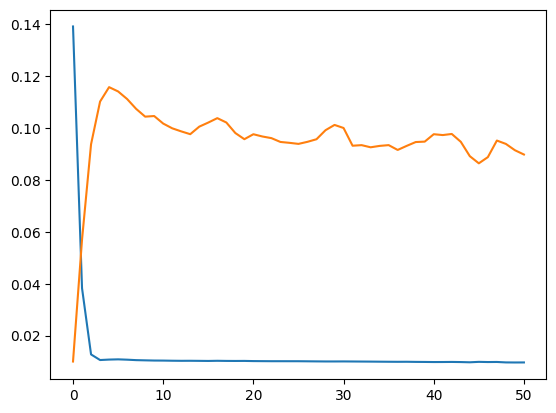

In [86]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

# Resultados obtidos

Comparando predições para as sequências separadas para teste

1/1 [==============================] - 0s 213ms/step


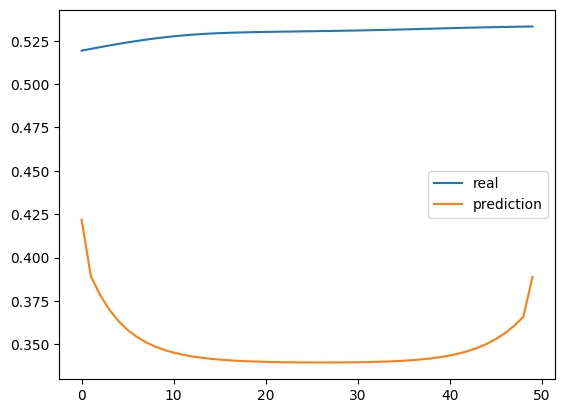

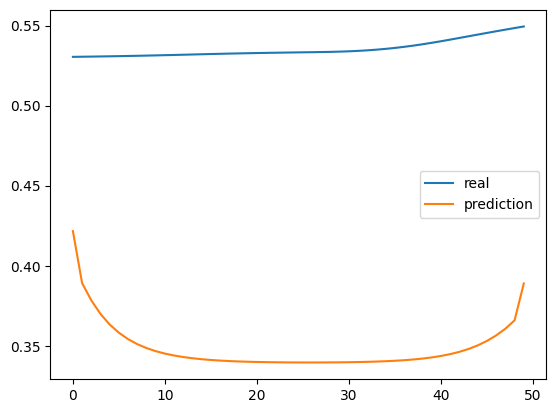

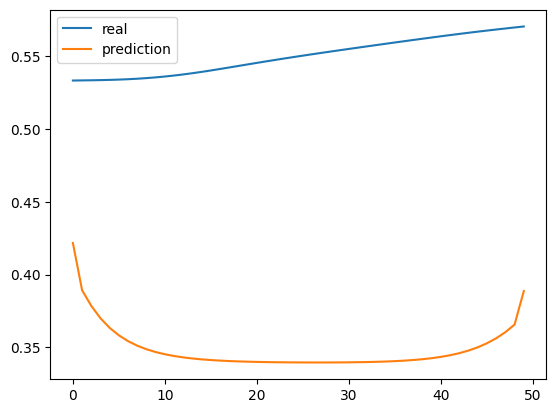

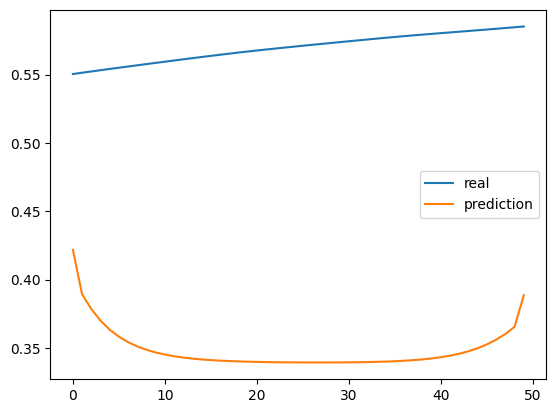

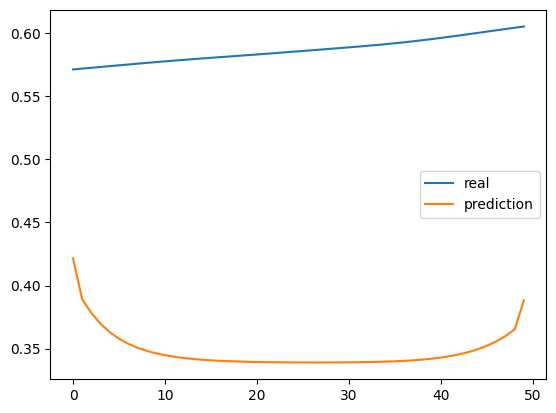

In [87]:
predictions = model.predict(inputs_test)
for i in range(5):
  plt.plot(outputs_test[i], label='real')
  plt.plot(predictions[i], label='prediction')
  plt.legend()
  plt.show()